## This Project has been DEPLOYED

## https://huggingface.co/spaces/AnoshDamania/Stock_Analysis_tool


In [ ]:
!pip install statsmodels.tsa

ERROR: Could not find a version that satisfies the requirement statsmodels.tsa (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [ ]:
import gradio as gr

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose

#### To get more insight into what is done in this function, check out this notebook
https://colab.research.google.com/drive/1vD_YPTJs29mKM_sNsQWgehWuwfVUJawd?usp=sharing

In [ ]:
def get_ans(inp):
  plt.close()
  tickers = yf.Tickers(inp)
  x = tickers.tickers[inp].history(period="15y")
  df = x
  df.reset_index(inplace=True)
  df1 = df.reset_index()['Close']
  df['Date'] = pd.to_datetime(df['Date'])
  scaler = MinMaxScaler(feature_range=(0, 1))
  df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
  training_size = int(len(df1) * 0.65)
  test_size = len(df1) - training_size
  train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]
  def create_dataset(dataset, time_step=1):
      dataX, dataY = [], []
      for i in range(len(dataset) - time_step - 1):
          a = dataset[i:(i + time_step), 0]
          dataX.append(a)
          dataY.append(dataset[i + time_step, 0])
      return np.array(dataX), np.array(dataY)
  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, ytest = create_dataset(test_data, time_step)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
  model.add(LSTM(50, return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2,batch_size=64,verbose=1)
  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)
  train_predict=scaler.inverse_transform(train_predict)
  test_predict=scaler.inverse_transform(test_predict)
  look_back=100
  trainPredictPlot = np.empty_like(df1)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(df1)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(df1))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)

  x_input=test_data[341:].reshape(1,-1)
  resize_var = x_input.size
  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()
  lst_output=[]
  n_steps=100
  i=0
  while(i<30):

      if(len(temp_input)>100):
          #print(temp_input)
          x_input=np.array(temp_input[1:])
          # print("{} day input {}".format(i,x_input))
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, x_input.size, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          # print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          #print(temp_input)
          lst_output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          # print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          # print(len(temp_input))
          lst_output.extend(yhat.tolist())
          i=i+1

  day_new=np.arange(1,101)
  day_pred=np.arange(101,131)

  df3=df1. tolist()
  df3.extend (lst_output)
  len_lis = len(lst_output)
  df3=pd.DataFrame(df3, columns=['Values'])
  df3['index']=range(1, len(df3) + 1)
  lst_output = pd.DataFrame(lst_output, columns=["Values"])
  lst_output['index']=range(1, len(lst_output) + 1)
  the_max = max(np.asarray(df['Open']))
  df3['Values'] = [i * the_max for i in df3['Values']]
  return plt, gr.update(visible=True,value=df, x="Date",y="Open", height=500, width=800),gr.update(visible=True,value=df[-300:], x="Date",y="Open", height=500, width=800),gr.update(visible=True,value=df[-30:], x="Date",y="Open", height=500, width=800), max(np.asarray(df['Open'])), min(np.asarray(df['Open'])), max(np.asarray(df['Open'])[-300:]), min(np.asarray(df['Open'][-300:])), max(np.asarray(df['Open'])[-30:]), min(np.asarray(df['Open'][-30:])), (max(np.asarray(df['Open']))) * (lst_output["Values"][0]), gr.update(visible=True,value=lst_output, x="index",y="Values", height=500, width=800),  gr.update(visible=True,value=df3, x="index",y="Values", height=500, width=800),  gr.update(visible=True,value=df3[-300:], x="index",y="Values", height=500, width=800)

In [ ]:
def get_seo(inp):
  plt.close()
  time_step = 100
  tickers = yf.Tickers(inp)
  x = tickers.tickers[inp].history(period="15y")
  df = x
  df.reset_index(inplace=True)
  df1 = df.reset_index()['Close']
  df['Date'] = pd.to_datetime(df['Date'])
  scaler = MinMaxScaler(feature_range=(0, 1))
  df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
  def create_dataset(dataset, time_step=1):
      dataX, dataY = [], []
      for i in range(len(dataset) - time_step - 1):
          a = dataset[i:(i + time_step), 0]
          dataX.append(a)
          dataY.append(dataset[i + time_step, 0])
      return np.array(dataX), np.array(dataY)
  X_train, y_train = create_dataset(df1, time_step)
  decompose_result_mult = seasonal_decompose(X_train, model="additive", period=time_step)
  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid

  z = [i[0] for i in trend]
  z = pd.DataFrame(z, columns=['Values'])
  z['index'] = range(1, len(z) + 1)

  y = [i[0] for i in seasonal]
  y = pd.DataFrame(y, columns=['Values'])
  y['index'] = range(1, len(z) + 1)

  a = [i[0] for i in residual]
  a = pd.DataFrame(a, columns=['Values'])
  a['index'] = range(1, len(a) + 1)

  return gr.update(visible=True, value=z, x='index', y='Values', height=500, width=800), gr.update(visible=True, value=y[:100], x='index', y='Values', height=500, width=800), gr.update(visible=True, value=a, x='index', y='Values', height=500, width=800)



In [ ]:
get_seo("GOOG")

({'visible': True,
  'value':       Values  index
  0        NaN      1
  1        NaN      2
  2        NaN      3
  3        NaN      4
  4        NaN      5
  ...      ...    ...
  3670     NaN   3671
  3671     NaN   3672
  3672     NaN   3673
  3673     NaN   3674
  3674     NaN   3675
  
  [3675 rows x 2 columns],
  'x': 'index',
  'y': 'Values',
  'height': 500,
  'width': 800,
  '__type__': 'generic_update'},
 {'visible': True,
  'value':       Values  index
  0  -0.002722      1
  1  -0.003631      2
  2  -0.002472      3
  3  -0.004233      4
  4  -0.003870      5
  ..       ...    ...
  95 -0.001733     96
  96 -0.002959     97
  97 -0.004007     98
  98 -0.003667     99
  99 -0.003228    100
  
  [100 rows x 2 columns],
  'x': 'index',
  'y': 'Values',
  'height': 500,
  'width': 800,
  '__type__': 'generic_update'},
 {'visible': True,
  'value':       Values  index
  0        NaN      1
  1        NaN      2
  2        NaN      3
  3        NaN      4
  4        NaN      5

In [ ]:
|def get_info(inp):
  tickers = yf.Ticker(inp)
  info = tickers.info
  balance = tickers.balance_sheet

  long_info= info['longBusinessSummary']
  curr_rat = info['currentRatio']
  quick_rat = info['quickRatio']
  short_rat = info['shortRatio']
  debt_eq = info['debtToEquity']
  volume = info['volume']
  market_cap = info['marketCap']
  curr_price = info['currentPrice']
  rev_per = info['revenuePerShare']





  return long_info, curr_rat, quick_rat, short_rat, debt_eq, volume, market_cap, curr_price, rev_per

In [ ]:
# get_ans('AAPL')

In [ ]:
def  get_balance(input):
  tickers = yf.Tickers(input)
  balance = tickers.balance_sheet
  return balance[1]

In [ ]:
get_info('TSLA')

('Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. It operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; purchase financing and leasing services; services for electric vehicles through its company-owned service locations and Tesla mobile service technicians; and vehicle limited warranties and extended service plans. The Energy Generation and Storage segment engages in the design, manufacture, installation, sale, and leasing of solar energy generation and energy storage products, and related 

In [ ]:
with gr.Blocks() as demo:
  with gr.Row().style(equal_height=True):
    with gr.Column():
      gr.Markdown("<center><h1>Stock Analysis Tool<h1></center>")
      gr.Markdown("<center><h3>Give the Ticker of the company you want to analyse. We will provide complete insights on the given company.</h3></center>")
      gr.Markdown("<center>To get the ticker of the company, click <a href = 'https://finance.yahoo.com/lookup/'>here.</a></center>")
  with gr.Row():
    with gr.Column():
      Name_of_the_company = gr.Textbox(placeholder="eg, GOOG / MSFT / AAPL", label="TICKER of the company")
      btn = gr.Button("ANALYSE")
      gr.Markdown("<center><h2>Analysis<h2></center>")
      gr.Markdown("<center><h3>Inportant Information</h3></center>")
      info1 = gr.Textbox()
      gr.Markdown("<h4>Insightful Ratios</h4>")
      with gr.Row():
        ratio1 = gr.Textbox(label='Current Ratio')
        ratio2 = gr.Textbox(label='Quick Ratio')
        ratio3 = gr.Textbox(label='Short Ratio')
        ratio4 = gr.Textbox(label='Debt to Equity Ratio')

      gr.Markdown("<center><h3>General Information</h3></center>")
      with gr.Row():
        curr_price = gr.Textbox(label='Current Price of Stock')
        rev_per = gr.Textbox(label='Revenue per Share')
      vol = gr.Textbox(label='Volume')
      mar_cap = gr.Textbox(label='Market Cap')

      gr.Markdown("<h3>Regression Trends of Price<h3>")
      with gr.Tab("Overall Trend"):
        trend_g = gr.LinePlot(visible=False, label='Trend of stock over its lifetime', height=1000, width=1000)
      with gr.Tab("Seasonal Trends"):
        Seaso = gr.LinePlot(visible=False,label="This is for one season", height=1000, width=1000)
      with gr.Tab("Residual Variation"):
        resid = gr.LinePlot(visible=False, label="Residual Variation over time", height=1000, width=1000)


      mp = gr.Plot()
      gr.Markdown("<h3>Price over time<h3>")
      with gr.Tab("All Time"):
        mp1 = gr.LinePlot(visible=False, label="All time", height=1000, width=1000)
        with gr.Row():
          Max_all = gr.Textbox(placeholder="The Maximum price the stock has ever reached", label='Maximum of all time')
          Min_all = gr.Textbox(placeholder="The Minimum price the stock has ever reached", label="Minimum of all time")
      with gr.Tab("Past year"):
        mp2 = gr.LinePlot(visible=False, label="Last year")
        with gr.Row():
          Max_year = gr.Textbox(placeholder="The Maximum price for the last year", label='Maximum')
          Min_year = gr.Textbox(placeholder="The Minimum price for the last year", label="Minimum")
      with gr.Tab("Past few Days"):

        mp3 = gr.LinePlot(visible=False, label="Past few Days")
        with gr.Row():
          Max_rec = gr.Textbox(placeholder="The Maximum price for the last few days", label='Recent Maximum')
          Min_rec = gr.Textbox(placeholder="The Minimum price for the last few days", label="Recent Minimum")
      gr.Markdown("<center><h2>Predictive Analysis</h2></center>")
      Next_day = gr.Textbox(placeholder="Predicted price for tomorrow", label="Predicted price for Tomorrow")
      Next_plot = gr.LinePlot(visible=False)
      Next_plot_all = gr.LinePlot(visible=False)
      Next_plot_year = gr.LinePlot(visible=False)


      btn.click(get_ans, inputs=Name_of_the_company, outputs= [mp,mp1,mp2,mp3, Max_all, Min_all,Max_year, Min_year, Max_rec, Min_rec, Next_day, Next_plot, Next_plot_all, Next_plot_year])
      btn.click(get_info, inputs=Name_of_the_company, outputs=[info1, ratio1, ratio2, ratio3, ratio4, vol, mar_cap, curr_price, rev_per])
      btn.click(get_seo, inputs=Name_of_the_company, outputs=[trend_g, Seaso, resid])

demo.launch()

<ipython-input-8-7e88f9bfa821>:2: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  with gr.Row().style(equal_height=True):


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## Everything below this point is not deployed, it was just for experimenting and stuff

In [ ]:
tickers = yf.Ticker("TSLA")
print(tickers.info.keys())

dict_keys(['address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry', 'industryDisp', 'sector', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'payoutRatio', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding', 'sharesShort', 'sharesShortPriorMonth', 'sharesShortPrevio

In [ ]:
tickers.actions

,Dividends,Stock Splits
Date,,
2020-08-31 00:00:00-04:00,0.0,5.0
2022-08-25 00:00:00-04:00,0.0,3.0


In [ ]:
tickers.dividends

Series([], Name: Dividends, dtype: float64)

In [ ]:
tickers.splits

Date
2020-08-31 00:00:00-04:00    5.0
2022-08-25 00:00:00-04:00    3.0
Name: Stock Splits, dtype: float64

In [ ]:
tickers.capital_gains

[]

In [ ]:
# tickers.balance_sheet['2022-09-30']

In [ ]:
tickers.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. It operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; purchase financing and leasing services; services for electric vehicles through its compa

In [ ]:
tickers.balance_sheet

,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Ordinary Shares Number,3164000000.0,3099000000.0,2880000000.0,2715931290.0
Share Issued,3164000000.0,3099000000.0,2880000000.0,2715931290.0
Net Debt,NaN,NaN,NaN,7151000000.0
Total Debt,3099000000.0,6834000000.0,11739000000.0,13419000000.0
Tangible Book Value,44111000000.0,28472000000.0,21705000000.0,6081000000.0
...,...,...,...,...
Receivables,2952000000.0,1913000000.0,1886000000.0,1324000000.0
Accounts Receivable,2952000000.0,1913000000.0,1886000000.0,1324000000.0
Cash Cash Equivalents And Short Term Investments,22185000000.0,17707000000.0,19384000000.0,6268000000.0
Other Short Term Investments,5932000000.0,131000000.0,NaN,NaN


In [ ]:
tickers.info['currentRatio']

1.567

In [ ]:
df = tickers.history(period='15y')

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-29 00:00:00-04:00,258.029999,260.739990,253.610001,257.500000,131283400,0.0,0.0
2023-06-30 00:00:00-04:00,260.600006,264.450012,259.890015,261.769989,112267600,0.0,0.0
2023-07-03 00:00:00-04:00,276.489990,284.250000,275.109985,279.820007,119685900,0.0,0.0


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df.reset_index(inplace=True)
df1 = df.reset_index()['Close']
df['Date'] = pd.to_datetime(df['Date'])
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 100
X_train, y_train = create_dataset(df1, time_step)

In [ ]:
decompose_result_mult = seasonal_decompose(X_train, model="additive", period=200)

In [ ]:
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

In [ ]:
z = [i[0] for i in trend]

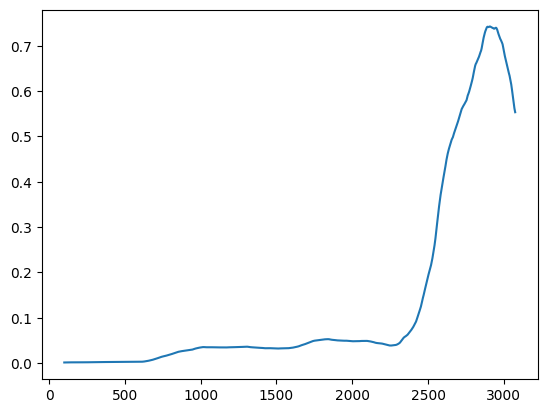

In [ ]:
plt.plot(z)